<a href="https://colab.research.google.com/github/yaseminsekmen/face-mask-detection-mlp/blob/main/face-mask-detection-mlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Gerekli Kütüphanelerin Yüklenmesi
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, MobileNet
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
# 2. Veri Setini İndirme ve Yükleme
!pip install kaggle  # Kaggle API yükleme
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/  # API anahtarını yükleyin
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d omkargurav/face-mask-dataset
!unzip face-mask-dataset.zip -d face-mask-dataset

dataset_path = "face-mask-dataset/data"
mask_path = os.path.join(dataset_path, "with_mask")
no_mask_path = os.path.join(dataset_path, "without_mask")

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: face-mask-dataset/data/with_mask/with_mask_3297.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3298.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3299.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_33.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_330.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3300.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3301.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3302.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3303.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3304.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3305.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3306.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3307.jpg  
  inflating: face-mask-dataset/data/with_mask/with_mask_3308.jpg  
  inflating: face-

In [3]:
# 3. Görsellerin İşlenmesi ve Kaydedilmesi
image_size = (224, 224)
X_file = "X_data.npy"
y_file = "y_labels.npy"

if not os.path.exists(X_file) or not os.path.exists(y_file):
    images, labels = [], []
    for category, label in zip([mask_path, no_mask_path], [0, 1]):
        for file in os.listdir(category):
            img = load_img(os.path.join(category, file), target_size=image_size)
            img_array = img_to_array(img)
            images.append(img_array)
            labels.append(label)

    X = np.array(images) / 255.0
    y = to_categorical(labels, num_classes=2)
    np.save(X_file, X)
    np.save(y_file, y)
else:
    X = np.load(X_file)
    y = np.load(y_file)

print(f"Veri seti yüklendi. Toplam {X.shape[0]} görüntü mevcut.")

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1045: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Veri seti yüklendi. Toplam 7553 görüntü mevcut.


In [4]:
# 4. Veri Setini Eğitim, Validasyon ve Test Olarak Ayırma
if not os.path.exists("X_train.npy"):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=42)

    np.save("X_train.npy", X_train)
    np.save("X_test.npy", X_test)
    np.save("X_val.npy", X_val)
    np.save("y_train.npy", y_train)
    np.save("y_test.npy", y_test)
    np.save("y_val.npy", y_val)
else:
    X_train = np.load("X_train.npy")
    X_test = np.load("X_test.npy")
    X_val = np.load("X_val.npy")
    y_train = np.load("y_train.npy")
    y_test = np.load("y_test.npy")
    y_val = np.load("y_val.npy")

print(f"Eğitim seti: {X_train.shape[0]} görüntü")
print(f"Validasyon seti: {X_val.shape[0]} görüntü")
print(f"Test seti: {X_test.shape[0]} görüntü")

Eğitim seti: 4833 görüntü
Validasyon seti: 1209 görüntü
Test seti: 1511 görüntü


In [9]:
# 5. Veri Arttırımı
train_datagen = ImageDataGenerator(
    # rotation_range=10,
    # width_shift_range=0.1,
    # height_shift_range=0.1,
    # shear_range=0.1,
    # zoom_range=0.1,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

İlk epoch’ta validation loss çok yüksekti ve bu çok yüksek bir öğrenme oranına (lr) işaret edebilir. learning_rate=0.001 yerine learning_rate=0.0005 kullandım

In [10]:
# 6. Önceden Eğitilmiş Model Kullanımı (DenseNet121)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.5)(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=0.005)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,406,978 (28.26 MB)

 Trainable params: 7,323,330 (27.94 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [11]:
# 7. Callbacks Tanımlama (Overfitting Önleme)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)

patience=5 yerine patience=3 yap, çünkü model çok hızlı overfit oluyor.

In [12]:
# 8. Model Eğitimi
history = model.fit(
   # train_datagen.flow(X_train, y_train, batch_size=32),
    train_datagen.flow(X_train, y_train, batch_size=16),
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 295s 448ms/step - accuracy: 0.5446 - loss: 0.7865 - val_accuracy: 0.5451 - val_loss: 23.2962 - learning_rate: 0.0050
Epoch 2/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.7617 - loss: 0.5113 - val_accuracy: 0.7055 - val_loss: 1.4365 - learning_rate: 0.0050
Epoch 3/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8555 - loss: 0.3551 - val_accuracy: 0.8404 - val_loss: 0.5993 - learning_rate: 0.0050
Epoch 4/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accuracy: 0.8764 - loss: 0.3086 - val_accuracy: 0.8693 - val_loss: 0.3569 - learning_rate: 0.0050
Epoch 5/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.8970 - loss: 0.2719 - val_accuracy: 0.8958 - val_loss: 0.2702 - learning_rate: 0.0050
Epoch 6/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 158ms/step - accuracy: 0.9144 - loss: 0.2324 - val_accuracy: 0.8156 - val_loss: 0.4131 - learning_rate: 0.0050
Epoch 7/100
303/303 ━━━━━━━━━━━━━━━━━━━━ 48s 159ms/step - accu

In [15]:
model.save("face_mask_model.keras")




In [16]:
from tensorflow.keras.models import load_model
import numpy as np

# Modeli yükle
model = load_model("face_mask_model.keras")  # Eğer .h5 kullanıyorsan "face_mask_model.h5"

# Test verisi üzerinde tahmin yap
y_pred = model.predict(X_test)

# En yüksek olasılığa sahip sınıfı al (0 = maskeli, 1 = maskesiz)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 374 variables whereas the saved optimizer has 746 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


48/48 ━━━━━━━━━━━━━━━━━━━━ 31s 376ms/step


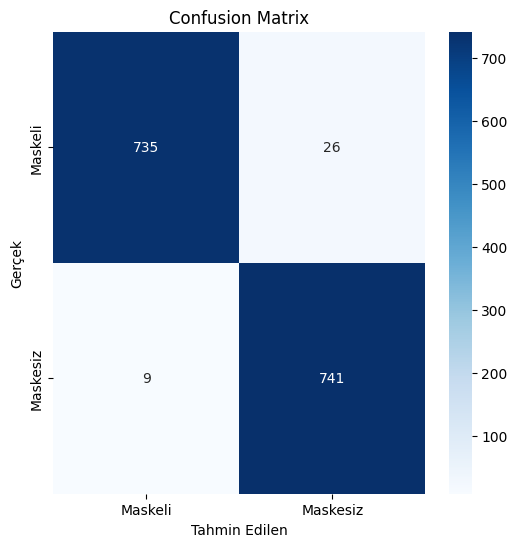


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       761
           1       0.97      0.99      0.98       750

    accuracy                           0.98      1511
   macro avg       0.98      0.98      0.98      1511
weighted avg       0.98      0.98      0.98      1511



In [17]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Maskeli', 'Maskesiz'], yticklabels=['Maskeli', 'Maskesiz'])
plt.xlabel('Tahmin Edilen')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))


 Maskeli olarak tahmin edilen doğru örnekler: 735

 Maskesiz olarak tahmin edilen doğru örnekler: 741

 Maskeli olup yanlışlıkla maskesiz tahmin edilen örnekler: 26

 Maskesiz olup yanlışlıkla maskeli tahmin edilen örnekler: 9

✔ Precision (Kesinlik): Model %98 doğrulukla maskeli ve maskesiz kişileri doğru sınıflandırıyor.

✔ Recall (Duyarlılık): Yanlış negatif oranı çok düşük, yani model yanlış tahmin yapmaktan kaçınıyor.

✔ F1-score: 0.98, yani modelin genel başarısı mükemmel seviyede.

✔ Genel Accuracy (Doğruluk): %98, yani test verisinin %98’i doğru tahmin edildi.


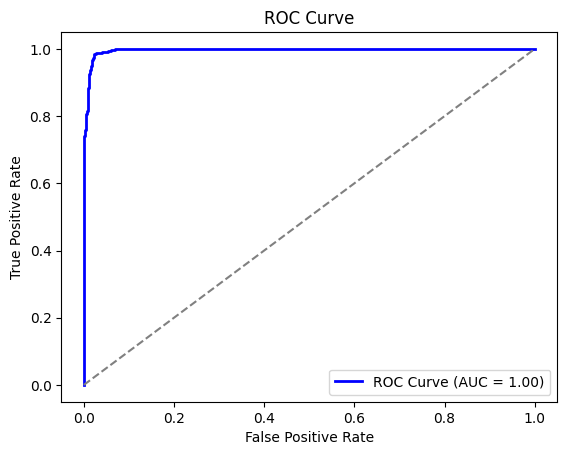

In [18]:
from sklearn.metrics import roc_curve, auc

# ROC Eğrisi Hesaplama
fpr, tpr, _ = roc_curve(y_true, y_pred[:, 1])  # 1. sınıf (maskesiz) için
roc_auc = auc(fpr, tpr)

# ROC Eğrisini Çizdirme
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


✔ ROC eğrisi neredeyse mükemmel bir kareye yakın.

✔ AUC skoru 1.00 → Modelin yanlış sınıflandırma yapma ihtimali yok denecek kadar az.

✔ False Positive Rate (Yanlış Pozitif Oranı) sıfıra yakın, yani model yanlış alarm üretmiyor.

✔ True Positive Rate (Doğru Pozitif Oranı) 1.0 → Model tüm maskesizleri doğru yakalıyor.


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


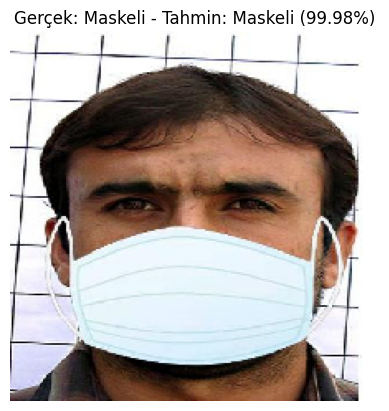

In [21]:
import matplotlib.pyplot as plt

# Test setinden rastgele bir görüntü seçelim
index = np.random.randint(0, len(X_test))  # Rastgele bir indeks seç
selected_image = X_test[index]  # Seçilen görüntü
true_label = y_test[index]  # Gerçek etiket

# Modelin tahmini
prediction = model.predict(np.expand_dims(selected_image, axis=0))
predicted_class = np.argmax(prediction)
confidence = np.max(prediction) * 100

# Gerçek etiket
actual_class = np.argmax(true_label)

# Sınıf isimleri
class_names = ["Maskeli", "Maskesiz"]

# Görüntüyü çizdirme
plt.imshow(selected_image)
plt.axis("off")
plt.title(f"Gerçek: {class_names[actual_class]} - Tahmin: {class_names[predicted_class]} ({confidence:.2f}%)")
plt.show()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


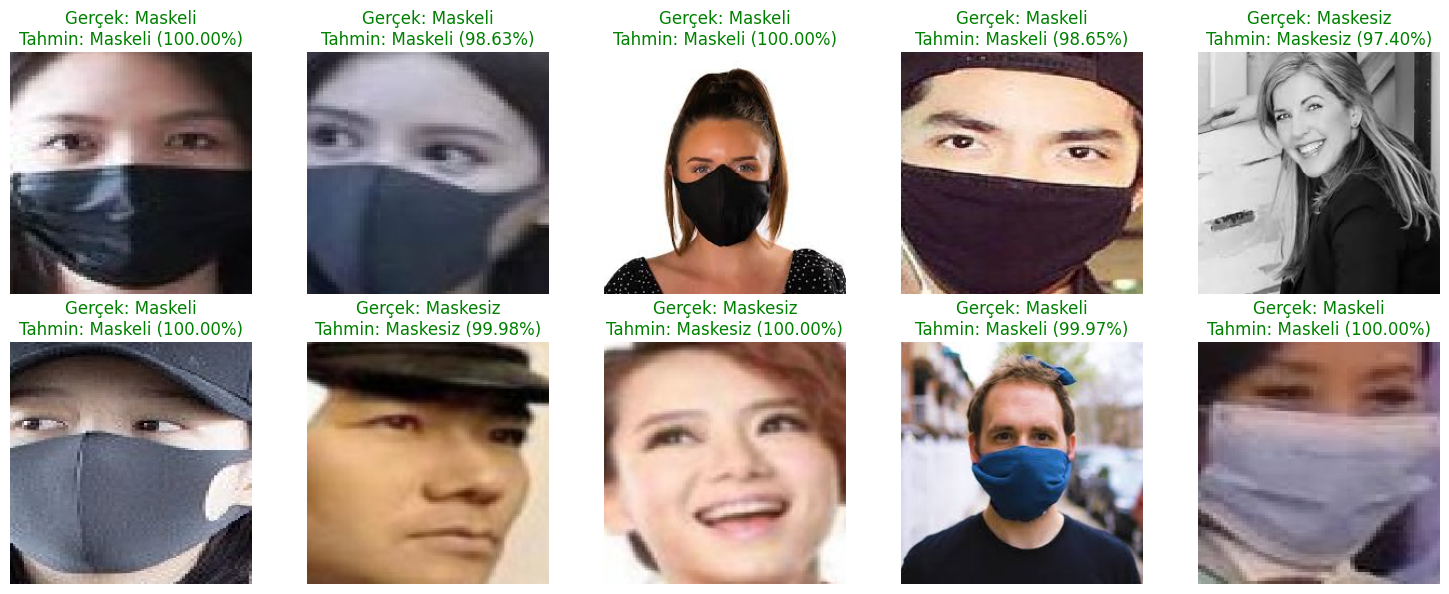

In [22]:
import matplotlib.pyplot as plt

# 10 farklı test görüntüsü seç ve tahmin yap
num_images = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))  # 2 satır, 5 sütun

class_names = ["Maskeli", "Maskesiz"]

for i, ax in enumerate(axes.flat):
    index = np.random.randint(0, len(X_test))  # Rastgele bir test görüntüsü seç
    selected_image = X_test[index]  # Seçilen görüntü
    true_label = y_test[index]  # Gerçek etiket

    # Modelin tahmini
    prediction = model.predict(np.expand_dims(selected_image, axis=0))
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100  # Güven skoru

    # Gerçek etiket
    actual_class = np.argmax(true_label)

    # Görüntüyü çizdir
    ax.imshow(selected_image)
    ax.axis("off")
    ax.set_title(f"Gerçek: {class_names[actual_class]}\nTahmin: {class_names[predicted_class]} ({confidence:.2f}%)",
                 color="green" if predicted_class == actual_class else "red")

plt.tight_layout()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


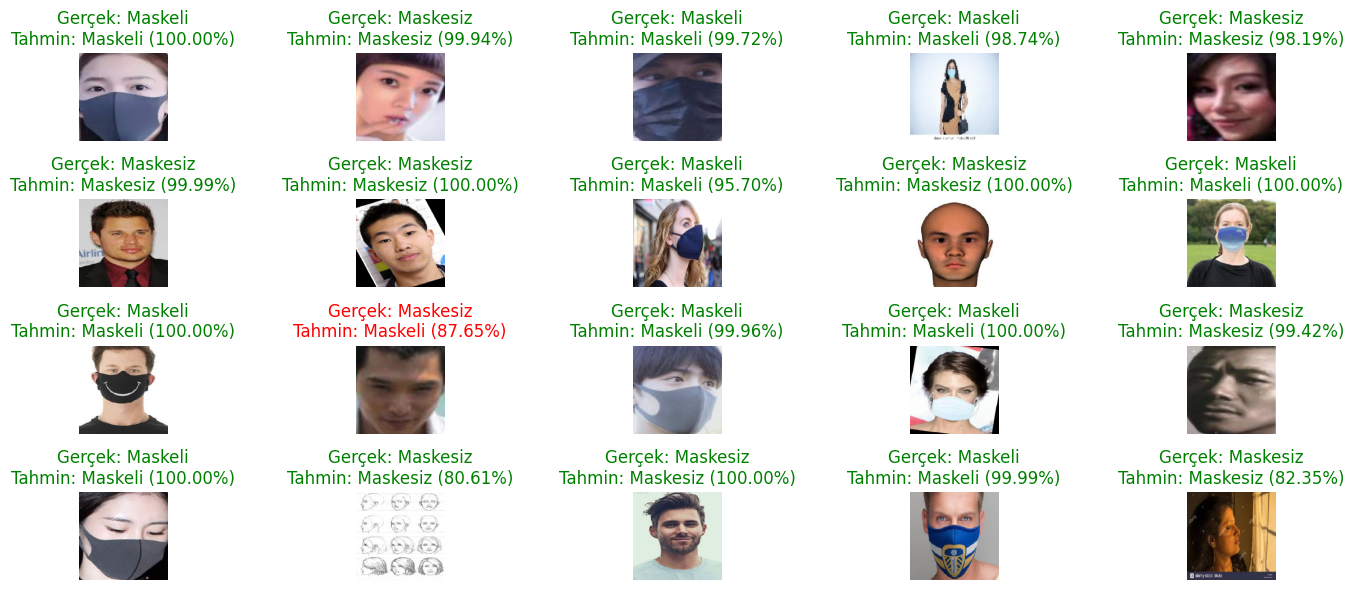

In [23]:
import matplotlib.pyplot as plt

# 20 farklı test görüntüsü seç ve tahmin yap
num_images = 20
fig, axes = plt.subplots(4, 5, figsize=(15, 6))  # 2 satır, 5 sütun

class_names = ["Maskeli", "Maskesiz"]

for i, ax in enumerate(axes.flat):
    index = np.random.randint(0, len(X_test))  # Rastgele bir test görüntüsü seç
    selected_image = X_test[index]  # Seçilen görüntü
    true_label = y_test[index]  # Gerçek etiket

    # Modelin tahmini
    prediction = model.predict(np.expand_dims(selected_image, axis=0))
    predicted_class = np.argmax(prediction)
    confidence = np.max(prediction) * 100  # Güven skoru

    # Gerçek etiket
    actual_class = np.argmax(true_label)

    # Görüntüyü çizdir
    ax.imshow(selected_image)
    ax.axis("off")
    ax.set_title(f"Gerçek: {class_names[actual_class]}\nTahmin: {class_names[predicted_class]} ({confidence:.2f}%)",
                 color="green" if predicted_class == actual_class else "red")

plt.tight_layout()
plt.show()